In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction-clinical-records/heart_failure_clinical_records.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

In [3]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction-clinical-records/heart_failure_clinical_records.csv')

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       5000 non-null   float64
 1   anaemia                   5000 non-null   int64  
 2   creatinine_phosphokinase  5000 non-null   int64  
 3   diabetes                  5000 non-null   int64  
 4   ejection_fraction         5000 non-null   int64  
 5   high_blood_pressure       5000 non-null   int64  
 6   platelets                 5000 non-null   float64
 7   serum_creatinine          5000 non-null   float64
 8   serum_sodium              5000 non-null   int64  
 9   sex                       5000 non-null   int64  
 10  smoking                   5000 non-null   int64  
 11  time                      5000 non-null   int64  
 12  DEATH_EVENT               5000 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 507.9 KB


In [6]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
df = df.drop_duplicates()

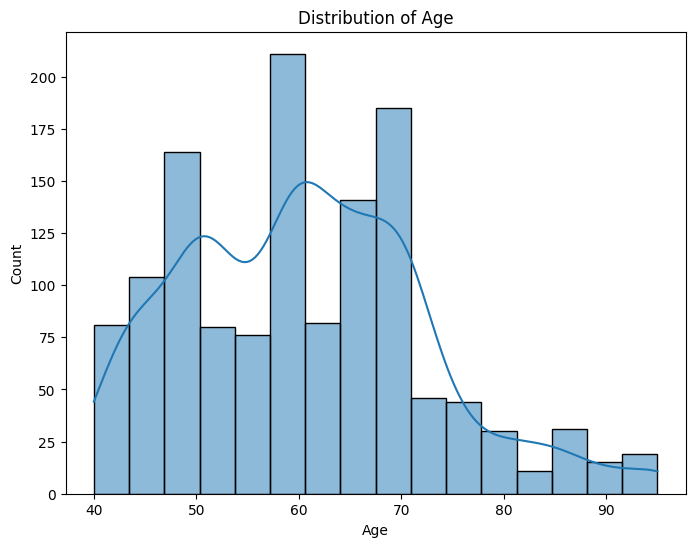

In [8]:
# Replace infinity values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

warnings.filterwarnings('ignore', category=FutureWarning)

# Distribution of age
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

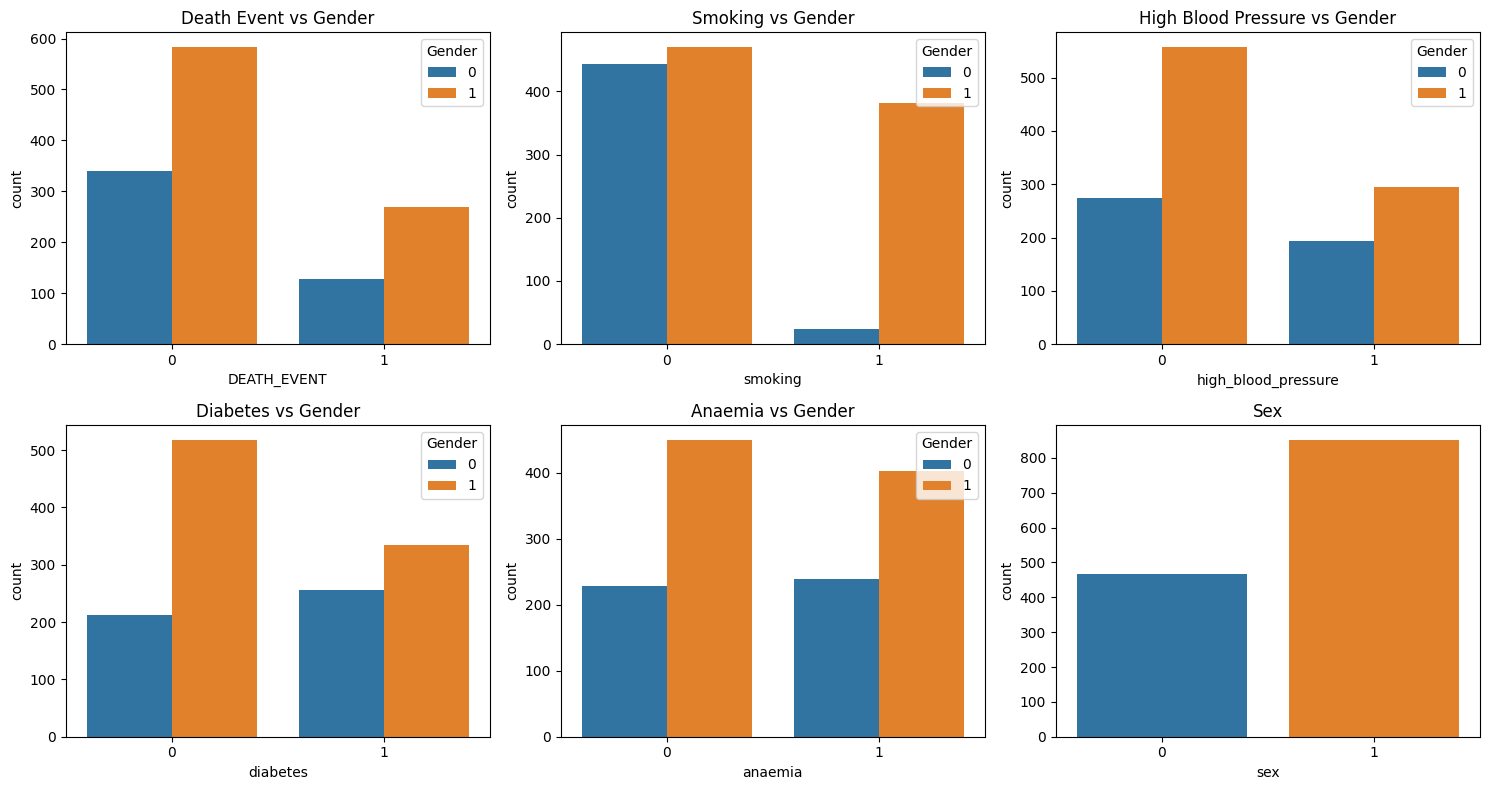

In [9]:
# DEATH_EVENT, smoking, high_blood_pressure, diabetes, anaemia vs gender and sex
categorical_features = ['DEATH_EVENT', 'smoking', 'high_blood_pressure', 'diabetes', 'anaemia', 'sex']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    if feature == 'sex':
        sns.countplot(x=feature, data=df, ax=axes[i])
        axes[i].set_title(f'{feature.replace("_", " ").title()}')
    else:
        sns.countplot(x=feature, hue='sex', data=df, ax=axes[i])
        axes[i].set_title(f'{feature.replace("_", " ").title()} vs Gender')
        axes[i].legend(title='Gender', loc='upper right')

plt.tight_layout()
plt.show()

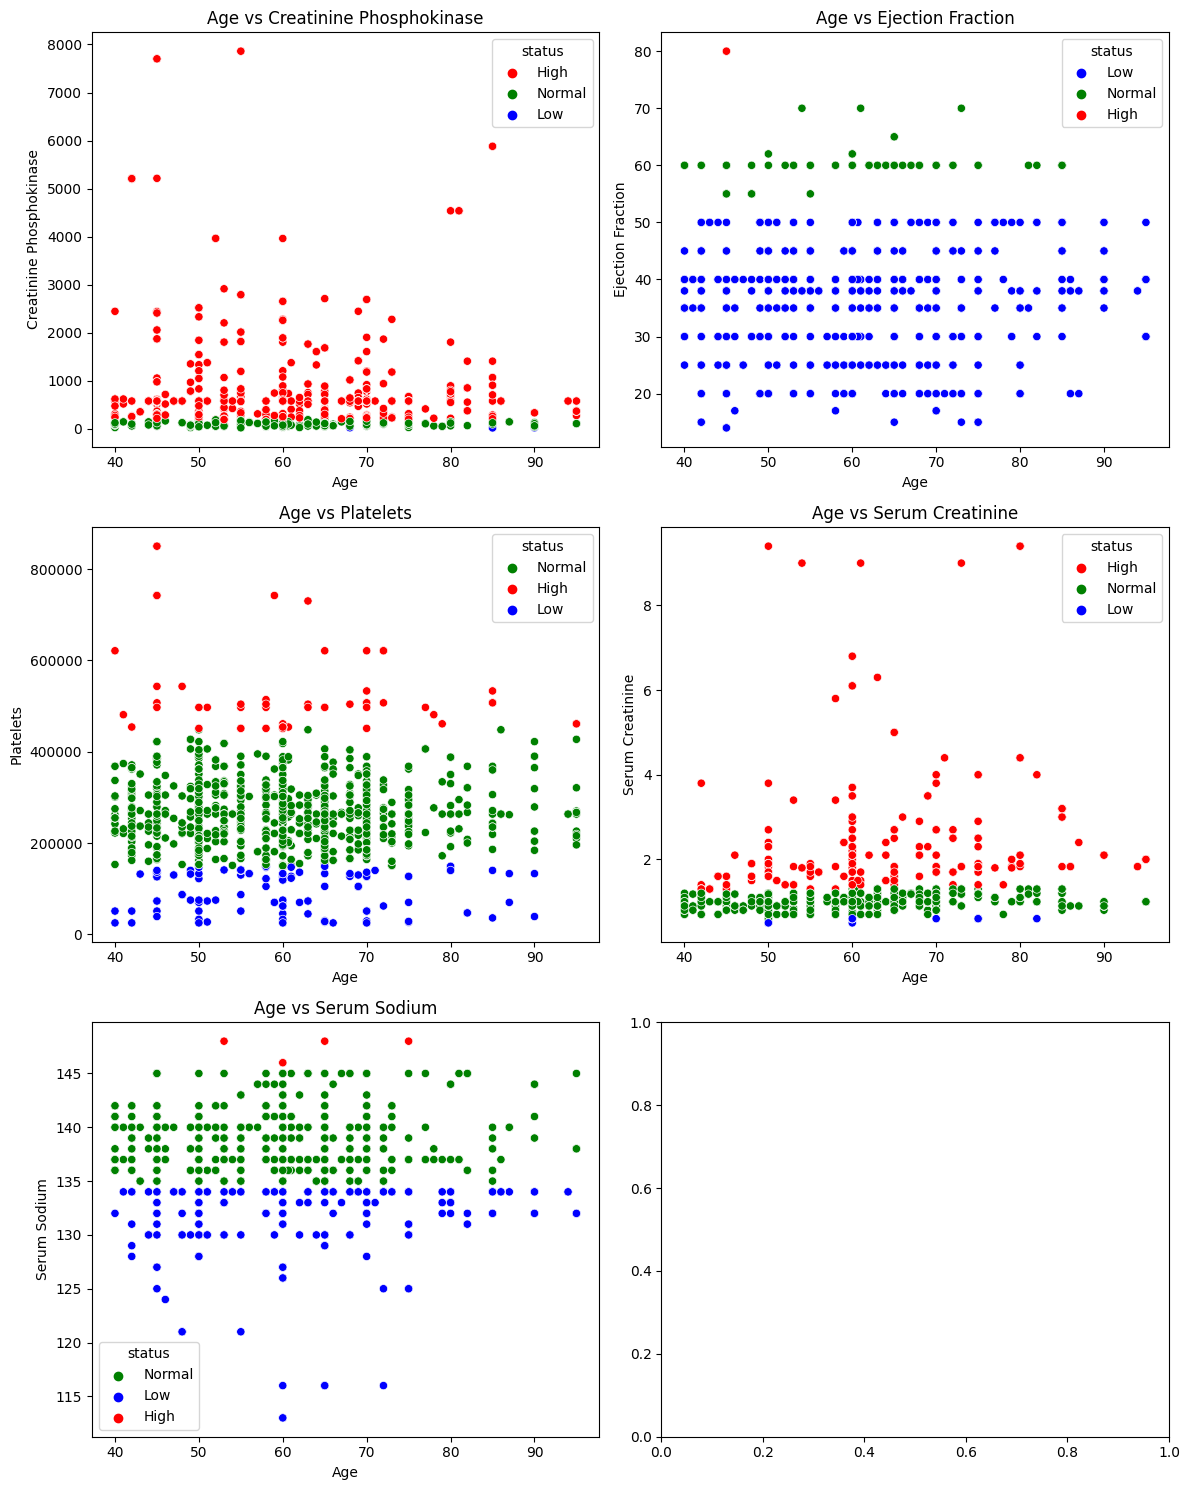

In [10]:
# Define normal ranges for each numerical feature based on age
normal_ranges = {
    'creatinine_phosphokinase': lambda age: (24, 190) if age < 60 else (30, 200),
    'ejection_fraction': lambda age: (55, 70),
    'platelets': lambda age: (150000, 450000),
    'serum_creatinine': lambda age: (0.6, 1.2) if age < 60 else (0.7, 1.3),
    'serum_sodium': lambda age: (135, 145), 
}

# Function to determine if a value is within the normal range
def is_within_normal_range(value, feature, age):
    if pd.isna(value) or pd.isna(age):
        return 'Unknown'
    lower, upper = normal_ranges[feature](age)
    if lower is None or upper is None:
        return 'Normal'
    elif value < lower:
        return 'Low'
    elif value > upper:
        return 'High'
    else:
        return 'Normal'

# Age with creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium
numerical_features = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axes = axes.flatten()

# Define a color palette for Low, Normal, and High values
color_palette = {'Low': 'blue', 'Normal': 'green', 'High': 'red'}

for i, feature in enumerate(numerical_features):
    # Determine the status (Low, Normal, High) for each data point
    df['status'] = df.apply(lambda row: is_within_normal_range(row[feature], feature, row['age']), axis=1)
    
    # Create the scatterplot with colored points based on status
    sns.scatterplot(x='age', y=feature, data=df, hue='status', ax=axes[i], palette=color_palette)
    axes[i].set_title(f'Age vs {feature.replace("_", " ").title()}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel(feature.replace('_', ' ').title())

plt.tight_layout()
plt.show()

In [11]:
# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_numeric, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numerical Features)', fontsize=16)
plt.xticks(rotation=45)
plt.show()

NameError: name 'corr_numeric' is not defined

<Figure size 2000x1600 with 0 Axes>